# 风格迁移

阅读内容和风格图像

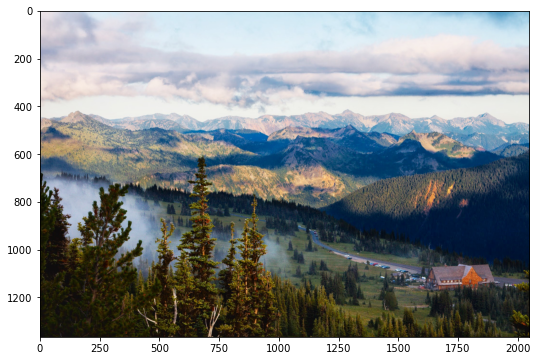

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "..")
import torch
import torchvision
import numpy as np
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l

device = "cuda:0"

def open_image(fpath):
    """Open the image given at fpath."""
    with open(fpath, "rb") as f:
        return np.asarray(Image.open(f))

content_img = Image.open('../img/rainier.jpg')
plt.figure(figsize=(10, 6))
plt.imshow(content_img)

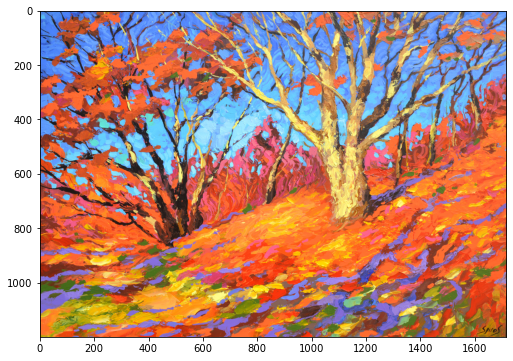

In [2]:
style_img = Image.open('../img/autumn-oak.jpg')
plt.figure(figsize=(10, 6))
plt.imshow(style_img)

预处理和后处理

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

抽取图像特征

In [4]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

定义损失函数

In [5]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).sum() * 0.5

def gram(X):
    num_channels = X.shape[1]
    F = X.permute(1, 0, 2, 3).reshape(num_channels, -1)
    return torch.matmul(F, F.T) / F.numel() / 2

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).sum()

def tv_loss(Y_hat):
    return (torch.square(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).sum() +
                  torch.square(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).sum())

风格转移的损失函数是内容损失、风格损失和总变化损失的加权和

In [6]:
content_weight, style_weight, tv_weight = 1, 1e3, 1e-6

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    contents_l = sum(contents_l) / len(contents_l)
    styles_l = sum(styles_l) / len(styles_l)
    total_loss = contents_l + styles_l + tv_l
    return contents_l, styles_l, tv_l, total_loss

训练模型

In [7]:
def optimize(X, contents_Y, styles_Y, device, n_iter):
    gen_img = X.clone().detach().requires_grad_(True)
    optimizer = torch.optim.LBFGS([gen_img])
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, n_iter],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(12, 5))
    
    def closure(ret_losses=False):
        optimizer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            gen_img, content_layers, style_layers)
        contents_l, styles_l, tv_l, total_loss = compute_loss(
            gen_img, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        total_loss.backward()
        if ret_losses:
            return contents_l, styles_l, tv_l
        return total_loss

    for i in range(n_iter):
        optimizer.step(closure)
        if (i + 1) % 10 == 0:
            contents_l, styles_l, tv_l = closure(True)
            animator.axes[1].imshow(postprocess(gen_img.clone().detach()))
            animator.add(i + 1, [float(contents_l), float(styles_l), float(tv_l)])
    return gen_img.clone().detach()

生成风格化图片

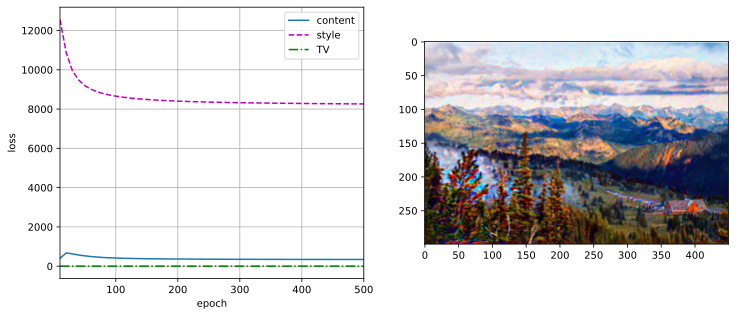

In [8]:
image_shape = (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = optimize(content_X, contents_Y, styles_Y, device, 500)